#Importacion de dependencias

---



In [ ]:
import re
import random
from google.colab import output

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History
from tensorflow.keras.layers import (
    Input,
    Embedding,
    LSTM,
    GRU,  # Choose GRU or LSTM for your model
    LayerNormalization,
    Dense,
    Dropout,
    Bidirectional,  # Optional for Bidirectional models
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Optional imports for data manipulation and preprocessing (uncomment if needed)
import numpy as np
import pandas as pd
import json

# Optional import for text classification (uncomment if needed)
from sklearn.preprocessing import LabelEncoder

# Optional import for serialization (uncomment if needed)
import pickle

#CARGAR Y MODIFICAR DATA


---



In [ ]:
# Cargar los datos del archivo JSON (asegúrate de tener el archivo chatbot_grados.json en tu entorno)
from google.colab import files
uploaded = files.upload()

with open("chatbot.json", 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])

# Almacenar datos que serán convertidos a DataFrame
dic = {"tag": [], "patterns": [], "responses": []}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]

    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)

# Crear un nuevo DataFrame a partir del diccionario
df = pd.DataFrame.from_dict(dic)

# Mostrar el DataFrame para verificar
df.head()

# Obtener las etiquetas únicas
df['tag'].unique()

Saving chatbot.json to chatbot.json


array(['Artículo 1 Finalidad', 'Artículo 5 Bachillerato automático',
       'Artículo 6 p1 Del Trabajo de Investigación',
       'Artículo 6 p2 Del Trabajo de Investigación',
       'Artículo 7 Procedimiento y Trámite', 'Artículo 8 Del trámite',
       'Artículo 12 Ceremonia de entrega de Diplomas de Bachiller',
       'Artículo 13 Del Título Profesional',
       'Artículo 15 Concepto de Proyecto de Tesis',
       'Artículo 18 Asesor del Proyecto de Tesis',
       'Artículo 22 Solicitud al Director de Escuela',
       'Artículo 23 Designación del Jurado del Proyecto de Tesis',
       'Artículo 24 Composición del Jurado dictaminador',
       'Artículo 29 Dictamen y presencia de Jurado del Proyecto de Tesis',
       'Artículo 32 Declaración de apto, no apto o improcedente en el dictamen',
       'Artículo 36 Procedimiento de Proyecto de tesis declarado apto',
       'Artículo 37 Plazo de ejecución de la Tesis',
       'Artículo 38 Nuevo Proyecto en caso de anulación',
       'Artículo 39

#TOKENIZACION (PRE PROCESSING)

In [ ]:
# Tokenización de textos
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(df['patterns'])
tokenizer.get_config()

# Obtener el tamaño del vocabulario
vocab_size = len(tokenizer.word_index)

# Preprocesamiento de secuencias y codificación de etiquetas
ptrn2seq = tokenizer.texts_to_sequences(df['patterns'])
X = pad_sequences(ptrn2seq, padding='post')

lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df['tag'])
num_classes = len(np.unique(y))

# Mostrar el tamaño del vocabulario y el número de clases
print('Tamaño del Vocabulario:', vocab_size)
print('Número de Clases:', num_classes)

# Mostrar una muestra de X y y
print('X:', X[:5])
print('y:', y[:5])

Tamaño del Vocabulario: 574
Número de Clases: 31
X: [[198   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 18 278   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [106  20 279 280   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 15 281  43   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [107 154   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]]
y: [0 0 0 0 0]


In [ ]:
# Preprocesamiento de secuencias y codificación de etiquetas
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
ptrn2seq = tokenizer.texts_to_sequences(df['patterns'])  # Convertir patrones de texto a secuencias
X = pad_sequences(ptrn2seq, padding='post')  # Aplicar padding a las secuencias
print('X shape = ', X.shape)  # Imprimir la forma de X

lbl_enc = LabelEncoder()  # Crear un codificador de etiquetas
y = lbl_enc.fit_transform(df['tag'])  # Codificar las etiquetas como números
print('y shape = ', y.shape)  # Imprimir la forma de y
print('num of classes = ', len(np.unique(y)))  # Imprimir el número de clases únicas

X shape =  (476, 24)
y shape =  (476,)
num of classes =  31


#LSTM

In [ ]:
modelLstm = Sequential()


modelLstm.add(Embedding(input_dim=vocab_size+1, output_dim=100, mask_zero=True))
modelLstm.add(LSTM(32, return_sequences=True))
modelLstm.add(LayerNormalization())

modelLstm.add(LSTM(32))
modelLstm.add(LayerNormalization())

modelLstm.add(Dense(256, activation="relu"))
modelLstm.add(LayerNormalization())
modelLstm.add(Dropout(0.5))

modelLstm.add(Dense(256, activation="relu"))
modelLstm.add(Dropout(0.5))

modelLstm.add(LayerNormalization())
modelLstm.add(Dense(len(np.unique(y)), activation="softmax"))


# Compilar el modelo
modelLstm.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Imprimir un resumen del modelo
modelLstm.summary()

# Visualizar la estructura del modelo
# plot_model(modelLstm, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         57500     
                                                                 
 lstm (LSTM)                 (None, None, 32)          17024     
                                                                 
 layer_normalization (Layer  (None, None, 32)          64        
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 layer_normalization_1 (Lay  (None, 32)                64        
 erNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               8

In [ ]:
# Entrenar el modelo
import tensorflow
model_history_LSTM = modelLstm.fit(x=X, y=y,
                           batch_size=10,
                           callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3),History()],
                           epochs=20)

Epoch 1/20
48/48 [==============================] - 13s 35ms/step - loss: 3.8228 - accuracy: 0.0924
Epoch 2/20
48/48 [==============================] - 2s 52ms/step - loss: 2.9583 - accuracy: 0.2290
Epoch 3/20
48/48 [==============================] - 2s 32ms/step - loss: 2.2202 - accuracy: 0.3739
Epoch 4/20
48/48 [==============================] - 2s 34ms/step - loss: 1.6326 - accuracy: 0.5441
Epoch 5/20
48/48 [==============================] - 2s 32ms/step - loss: 1.0901 - accuracy: 0.7017
Epoch 6/20
48/48 [==============================] - 2s 35ms/step - loss: 0.7935 - accuracy: 0.7962
Epoch 7/20
48/48 [==============================] - 2s 33ms/step - loss: 0.5266 - accuracy: 0.8571
Epoch 8/20
48/48 [==============================] - 2s 33ms/step - loss: 0.4025 - accuracy: 0.9076
Epoch 9/20
48/48 [==============================] - 2s 52ms/step - loss: 0.2985 - accuracy: 0.9349
Epoch 10/20
48/48 [==============================] - 2s 33ms/step - loss: 0.2341 - accuracy: 0.9538
Epoch 11

In [ ]:
# Guardar el Tokenizador

with open('tokenizer_lstm.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Guardar el Codificador de Etiquetas
with open('label_encoder_lstm.pkl', 'wb') as handle:
    pickle.dump(lbl_enc, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('historial_modelo_lstm.pkl', 'wb') as f:
    pickle.dump(model_history_LSTM.history, f)

# Guardar el Modelo LSTM
modelLstm.save("my_lstm_model.keras")

# Descargar los archivos generados
from google.colab import files
files.download('tokenizer_lstm.pkl')
files.download('label_encoder_lstm.pkl')
files.download('my_lstm_model.keras')
files.download('historial_modelo_lstm.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re

def inputan_user_LSTM(pattern):
    text = []
    txt = re.sub('[^a-zA-Z\']', ' ', pattern)
    txt = txt.lower()
    txt = txt.split()
    txt = " ".join(txt)
    text.append(txt)

    # Tokenizar y aplicar padding a la entrada
    x_test = tokenizer.texts_to_sequences(text)
    x_test = pad_sequences(x_test, padding='post', maxlen=18)

    # Hacer predicción usando el modelo
    y_pred = modelLstm.predict(x_test)
    y_pred = y_pred.argmax()
    tag = lbl_enc.inverse_transform([y_pred])[0]
    responses = df[df['tag'] == tag]['responses'].values[0]

    # Mostrar la entrada del usuario y la respuesta del bot
    print("User: {}".format(pattern))
    print(" BOT : {}".format(np.random.choice(responses)))


In [ ]:

inputan_user_LSTM("hola")

1/1 [==============================] - 4s 4s/step
User: hola
 BOT : ¡Hola! Soy un chatbot de AiMara y estoy aquí para ayudarte. Mi función es proporcionarte toda la información necesaria sobre los procedimientos, requisitos y criterios para obtener el Grado Académico de Bachiller y el Título Profesional en cada una de las Escuelas Profesionales de la Universidad Nacional de Moquegua, siempre siguiendo al pie de la letra la normativa vigente. 
 
 Mi misión principal es asegurarme de que tengas respuestas claras y precisas sobre las normas de administración que rigen estos procesos, ya que tanto el Grado Académico de Bachiller como el Título Profesional son reconocimientos importantes que la Universidad Nacional de Moquegua otorga en nombre de nuestra nación. 
 
 Estoy aquí para servirte, así que no dudes en acudir a mí si tienes alguna pregunta o necesitas orientación. Mi objetivo es brindarte la mejor ayuda posible, tanto si eres estudiante, egresado, bachiller, docente o autoridad de 

In [ ]:
# modelLstm.save("my_model.keras")

In [ ]:
# from tensorflow.keras.models import load_model


# model_path_school = 'my_model.keras'  # Update with the correct path
# modelo_cargado = load_model(model_path_school)

# # Debugging: Check the input shape of the loaded model
# print("Loaded Model Input Shape:", modelo_cargado.input_shape)

In [ ]:
# def inputan_user(pattern):
#   """
#   Procesa la entrada del usuario y genera una respuesta.

#   Args:
#     pattern: La entrada del usuario como cadena de texto.

#   Returns:
#     La respuesta del bot como cadena de texto.
#   """
#   text = []
#   txt = re.sub('[^a-zA-Z\']', ' ', pattern)
#   txt = txt.lower()
#   txt = txt.split()
#   txt = " ".join(txt)
#   text.append(txt)

#   # Tokenizar y aplicar padding a la entrada
#   x_test = tokenizer.texts_to_sequences(text)
#   x_test = pad_sequences(x_test, padding='post', maxlen=18)

#   # Hacer predicción usando el modelo
#   y_pred = modelo_cargado.predict(x_test)
#   y_pred = y_pred.argmax()
#   tag = lbl_enc.inverse_transform([y_pred])[0]
#   responses = df[df['tag'] == tag]['responses'].values[0]

#   return random.choice(responses)

In [ ]:
# def text_input():
#   """
#   Creates a new line and prompts the user for input.

#   Returns:
#     The user's input as a string.
#   """
#   print("\nEscribe tu pregunta: ", end="")
#   text = input()
#   return text


In [ ]:
# import re
# while True:
#   # Obtener la entrada del usuario
#   pattern = text_input()

#   # Procesar la entrada del usuario y generar una respuesta
#   respuesta = inputan_user(pattern)

#   # Mostrar la respuesta del bot
#   print("BOT:", respuesta)


## Graficos y tablas: LSTM

#BILSTM


In [ ]:
modelBiLSTM = Sequential()

# Capa de Embedding
modelBiLSTM.add(Embedding(input_dim=vocab_size + 1, output_dim=100, mask_zero=True))

# Capa BiLSTM
modelBiLSTM.add(Bidirectional(LSTM(32, return_sequences=True)))
modelBiLSTM.add(LayerNormalization())

# Capa BiLSTM (segunda capa)
modelBiLSTM.add(Bidirectional(LSTM(32)))
modelBiLSTM.add(LayerNormalization())

# Capa Densa 1
modelBiLSTM.add(Dense(256, activation="relu"))
modelBiLSTM.add(LayerNormalization())
modelBiLSTM.add(Dropout(0.5))

# Capa Densa 2
modelBiLSTM.add(Dense(256, activation="relu"))
modelBiLSTM.add(Dropout(0.5))

# Capa de Salida
modelBiLSTM.add(LayerNormalization())
modelBiLSTM.add(Dense(num_classes, activation="softmax"))

# Compilación del modelo
modelBiLSTM.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Resumen del modelo
modelBiLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         57500     
                                                                 
 bidirectional (Bidirection  (None, None, 64)          34048     
 al)                                                             
                                                                 
 layer_normalization_4 (Lay  (None, None, 64)          128       
 erNormalization)                                                
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 layer_normalization_5 (Lay  (None, 64)                128       
 erNormalization)                                     

In [ ]:
# Entrenamiento del modelo
model_history_BILSTM = modelBiLSTM.fit(x=X, y=y,
                          batch_size=10,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3),History()],
                          epochs=20)

Epoch 1/20
48/48 [==============================] - 30s 95ms/step - loss: 3.8583 - accuracy: 0.0756
Epoch 2/20
48/48 [==============================] - 3s 53ms/step - loss: 2.6530 - accuracy: 0.2710
Epoch 3/20
48/48 [==============================] - 3s 60ms/step - loss: 1.9561 - accuracy: 0.4370
Epoch 4/20
48/48 [==============================] - 4s 74ms/step - loss: 1.3609 - accuracy: 0.6282
Epoch 5/20
48/48 [==============================] - 3s 53ms/step - loss: 0.9977 - accuracy: 0.6933
Epoch 6/20
48/48 [==============================] - 3s 54ms/step - loss: 0.6802 - accuracy: 0.8172
Epoch 7/20
48/48 [==============================] - 3s 54ms/step - loss: 0.5739 - accuracy: 0.8424
Epoch 8/20
48/48 [==============================] - 4s 81ms/step - loss: 0.4076 - accuracy: 0.9034
Epoch 9/20
48/48 [==============================] - 3s 54ms/step - loss: 0.2474 - accuracy: 0.9454
Epoch 10/20
48/48 [==============================] - 3s 54ms/step - loss: 0.2362 - accuracy: 0.9454
Epoch 11

In [ ]:
# Guardar el Tokenizador

with open('tokenizer_bilstm.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Guardar el Codificador de Etiquetas
with open('label_encoder_bilstm.pkl', 'wb') as handle:
    pickle.dump(lbl_enc, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('historial_modelo_bilstm.pkl', 'wb') as f:
    pickle.dump(model_history_BILSTM.history, f)

# Guardar el Modelo BiLSTM
modelBiLSTM.save("my_bilstm_model.keras")

# Descargar los archivos generados
from google.colab import files
files.download('tokenizer_bilstm.pkl')
files.download('label_encoder_bilstm.pkl')
files.download('my_bilstm_model.keras')
files.download('historial_modelo_bilstm.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re
def inputan_user_BiLSTM(pattern):
    text = []
    txt = re.sub('[^a-zA-Z\']', ' ', pattern)
    txt = txt.lower()
    txt = txt.split()
    txt = " ".join(txt)
    text.append(txt)

    # Tokenizar y aplicar padding a la entrada
    x_test = tokenizer.texts_to_sequences(text)
    x_test = pad_sequences(x_test, padding='post', maxlen=18)

    # Hacer predicción usando el modelo
    y_pred = modelBiLSTM.predict(x_test)
    y_pred = y_pred.argmax()
    tag = lbl_enc.inverse_transform([y_pred])[0]
    responses = df[df['tag'] == tag]['responses'].values[0]

    # Mostrar la entrada del usuario y la respuesta del bot
    print("User: {}".format(pattern))
    print(" BOT : {}".format(np.random.choice(responses)))


In [ ]:
# Cargar el Modelo BiLSTM previamente guardado
model_path = 'my_bilstm_model.keras'
modelo_cargado = tf.keras.models.load_model(model_path)




In [ ]:
# Ejemplo de uso del chatbot BiLSTM
inputan_user_BiLSTM("Hola")

1/1 [==============================] - 6s 6s/step
User: Hola
 BOT : ¡Hola! Soy un chatbot de AiMara y estoy aquí para ayudarte. Mi función es proporcionarte toda la información necesaria sobre los procedimientos, requisitos y criterios para obtener el Grado Académico de Bachiller y el Título Profesional en cada una de las Escuelas Profesionales de la Universidad Nacional de Moquegua, siempre siguiendo al pie de la letra la normativa vigente. 
 
 Mi misión principal es asegurarme de que tengas respuestas claras y precisas sobre las normas de administración que rigen estos procesos, ya que tanto el Grado Académico de Bachiller como el Título Profesional son reconocimientos importantes que la Universidad Nacional de Moquegua otorga en nombre de nuestra nación. 
 
 Estoy aquí para servirte, así que no dudes en acudir a mí si tienes alguna pregunta o necesitas orientación. Mi objetivo es brindarte la mejor ayuda posible, tanto si eres estudiante, egresado, bachiller, docente o autoridad de 

#GRU

In [ ]:
modelGru = tf.keras.Sequential()

# Capa de Embedding
modelGru.add(Embedding(input_dim=vocab_size + 1, output_dim=100, mask_zero=True))

# Capa GRU
modelGru.add(GRU (32))
modelGru.add(LayerNormalization())

# Capa Densa 1
modelGru.add(Dense(256, activation="relu"))
modelGru.add(LayerNormalization())
modelGru.add(Dropout(0.5))

# Capa Densa 2
modelGru.add(Dense(256, activation="relu"))
modelGru.add(Dropout(0.5))

# Capa de Salida
modelGru.add(Dense(num_classes, activation="softmax"))

# Compilación del modelo
modelGru.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])


In [ ]:

# Compile the model
modelGru.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Model Summary

modelGru.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         57500     
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 layer_normalization_8 (Lay  (None, 32)                64        
 erNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               8448      
                                                                 
 layer_normalization_9 (Lay  (None, 256)               512       
 erNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [ ]:
# Entrenamiento del modelo
model_history_GRU = modelGru.fit(x=X, y=y,
                          batch_size=10,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3),History()],
                          epochs=20)

Epoch 1/20
48/48 [==============================] - 7s 18ms/step - loss: 4.0507 - accuracy: 0.0777
Epoch 2/20
48/48 [==============================] - 1s 19ms/step - loss: 3.0289 - accuracy: 0.2248
Epoch 3/20
48/48 [==============================] - 1s 19ms/step - loss: 2.5559 - accuracy: 0.2920
Epoch 4/20
48/48 [==============================] - 1s 19ms/step - loss: 2.1364 - accuracy: 0.3950
Epoch 5/20
48/48 [==============================] - 1s 19ms/step - loss: 1.9387 - accuracy: 0.4769
Epoch 6/20
48/48 [==============================] - 1s 20ms/step - loss: 1.6097 - accuracy: 0.5315
Epoch 7/20
48/48 [==============================] - 1s 25ms/step - loss: 1.3874 - accuracy: 0.6029
Epoch 8/20
48/48 [==============================] - 1s 29ms/step - loss: 1.2357 - accuracy: 0.6261
Epoch 9/20
48/48 [==============================] - 1s 26ms/step - loss: 1.1327 - accuracy: 0.6471
Epoch 10/20
48/48 [==============================] - 1s 20ms/step - loss: 0.8298 - accuracy: 0.7374
Epoch 11/

In [ ]:
# Guardar el Tokenizador
with open('tokenizer_gru.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Guardar el Codificador de Etiquetas
with open('label_encoder_gru.pkl', 'wb') as handle:
    pickle.dump(lbl_enc, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('historial_modelo_gru.pkl', 'wb') as f:
    pickle.dump(model_history_GRU.history, f)

# Guardar el Modelo BiLSTM
modelGru.save("my_gru_model.keras")

# Descargar los archivos generados
from google.colab import files
files.download('tokenizer_gru.pkl')
files.download('label_encoder_gru.pkl')
files.download('my_gru_model.keras')
files.download('historial_modelo_gru.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re
def inputan_user_Gru(pattern):
    text = []
    txt = re.sub('[^a-zA-Z\']', ' ', pattern)
    txt = txt.lower()
    txt = txt.split()
    txt = " ".join(txt)
    text.append(txt)

    # Tokenizar y aplicar padding a la entrada
    x_test = tokenizer.texts_to_sequences(text)
    x_test = pad_sequences(x_test, padding='post', maxlen=18)

    # Hacer predicción usando el modelo
    y_pred = modelGru.predict(x_test)
    y_pred = y_pred.argmax()
    tag = lbl_enc.inverse_transform([y_pred])[0]
    responses = df[df['tag'] == tag]['responses'].values[0]

    # Mostrar la entrada del usuario y la respuesta del bot
    print("User: {}".format(pattern))
    print(" BOT : {}".format(np.random.choice(responses)))


In [ ]:
# Cargar el Modelo BiLSTM previamente guardado
model_path = 'my_gru_model.keras'
modelo_cargado = tf.keras.models.load_model(model_path)




In [ ]:
inputan_user_Gru("Hola")

1/1 [==============================] - 2s 2s/step
User: Hola
 BOT : ¡Hola! Soy un chatbot de AiMara y estoy aquí para ayudarte. Mi función es proporcionarte toda la información necesaria sobre los procedimientos, requisitos y criterios para obtener el Grado Académico de Bachiller y el Título Profesional en cada una de las Escuelas Profesionales de la Universidad Nacional de Moquegua, siempre siguiendo al pie de la letra la normativa vigente. 
 
 Mi misión principal es asegurarme de que tengas respuestas claras y precisas sobre las normas de administración que rigen estos procesos, ya que tanto el Grado Académico de Bachiller como el Título Profesional son reconocimientos importantes que la Universidad Nacional de Moquegua otorga en nombre de nuestra nación. 
 
 Estoy aquí para servirte, así que no dudes en acudir a mí si tienes alguna pregunta o necesitas orientación. Mi objetivo es brindarte la mejor ayuda posible, tanto si eres estudiante, egresado, bachiller, docente o autoridad de 

#BiGru

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, LayerNormalization, Dense, Dropout

# Define the model
modelBiGru = keras.Sequential()

# Embedding layer for vocabulary size + 1 (including padding)
modelBiGru.add(Embedding(input_dim=vocab_size + 1, output_dim=100, mask_zero=True))

# First BGRU layer with return_sequences=True to process sequences
modelBiGru.add(Bidirectional(GRU(32, return_sequences=True)))
modelBiGru.add(LayerNormalization())  # Normalize activations for better training

# Second BGRU layer
modelBiGru.add(Bidirectional(GRU(32)))
modelBiGru.add(LayerNormalization())

# Dense layers with ReLU activation and dropout for regularization
modelBiGru.add(Dense(256, activation="relu"))
modelBiGru.add(LayerNormalization())
modelBiGru.add(Dropout(0.5))

modelBiGru.add(Dense(256, activation="relu"))
modelBiGru.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
modelBiGru.add(Dense(num_classes, activation="softmax"))


In [ ]:

# Compile the model
modelBiGru.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Model Summary

modelBiGru.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         57500     
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 64)          25728     
 onal)                                                           
                                                                 
 layer_normalization_10 (La  (None, None, 64)          128       
 yerNormalization)                                               
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                18816     
 onal)                                                           
                                                                 
 layer_normalization_11 (La  (None, 64)                128       
 yerNormalization)                                    

In [ ]:
# Entrenamiento del modelo
model_history_BIGRU = modelBiGru.fit(x=X, y=y,
                          batch_size=10,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3),History()],
                          epochs=20)



Epoch 1/20
48/48 [==============================] - 26s 61ms/step - loss: 4.2225 - accuracy: 0.0714
Epoch 2/20
48/48 [==============================] - 3s 59ms/step - loss: 3.1453 - accuracy: 0.1744
Epoch 3/20
48/48 [==============================] - 3s 66ms/step - loss: 2.5172 - accuracy: 0.2899
Epoch 4/20
48/48 [==============================] - 4s 76ms/step - loss: 1.9469 - accuracy: 0.4475
Epoch 5/20
48/48 [==============================] - 3s 52ms/step - loss: 1.4812 - accuracy: 0.5882
Epoch 6/20
48/48 [==============================] - 2s 49ms/step - loss: 1.1245 - accuracy: 0.6492
Epoch 7/20
48/48 [==============================] - 3s 57ms/step - loss: 0.8475 - accuracy: 0.7374
Epoch 8/20
48/48 [==============================] - 4s 81ms/step - loss: 0.5430 - accuracy: 0.8340
Epoch 9/20
48/48 [==============================] - 3s 57ms/step - loss: 0.4327 - accuracy: 0.8634
Epoch 10/20
48/48 [==============================] - 3s 58ms/step - loss: 0.4357 - accuracy: 0.8634
Epoch 11

In [ ]:
# Guardar el Tokenizador

with open('tokenizer_bigru.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Guardar el Codificador de Etiquetas
with open('label_encoder_bigru.pkl', 'wb') as handle:
    pickle.dump(lbl_enc, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('historial_modelo_bigru.pkl', 'wb') as f:
    pickle.dump(model_history_BIGRU.history, f)

# Guardar el Modelo BiLSTM
modelBiGru.save("my_bigru_model.keras")

# Descargar los archivos generados
from google.colab import files
files.download('tokenizer_bigru.pkl')
files.download('label_encoder_bigru.pkl')
files.download('my_bigru_model.keras')
files.download('historial_modelo_bigru.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import r
def inputan_user_BiGru(pattern):
    text = []
    txt = re.sub('[^a-zA-Z\']', ' ', pattern)
    txt = txt.lower()
    txt = txt.split()
    txt = " ".join(txt)
    text.append(txt)

    # Tokenizar y aplicar padding a la entrada
    x_test = tokenizer.texts_to_sequences(text)
    x_test = pad_sequences(x_test, padding='post', maxlen=18)

    # Hacer predicción usando el modelo
    y_pred = modelBiGru.predict(x_test)
    y_pred = y_pred.argmax()
    tag = lbl_enc.inverse_transform([y_pred])[0]
    responses = df[df['tag'] == tag]['responses'].values[0]

    # Mostrar la entrada del usuario y la respuesta del bot
    print("User: {}".format(pattern))
    print(" BOT : {}".format(np.random.choice(responses)))


In [ ]:
# Cargar el Modelo BiLSTM previamente guardado

model_path = 'my_bigru_model.keras'
modelo_cargado = tf.keras.models.load_model(model_path)




In [ ]:
inputan_user_BiGru("hola")

1/1 [==============================] - 6s 6s/step
User: hola
 BOT : ¡Hola! Soy un chatbot de AiMara y estoy aquí para ayudarte. Mi función es proporcionarte toda la información necesaria sobre los procedimientos, requisitos y criterios para obtener el Grado Académico de Bachiller y el Título Profesional en cada una de las Escuelas Profesionales de la Universidad Nacional de Moquegua, siempre siguiendo al pie de la letra la normativa vigente. 
 
 Mi misión principal es asegurarme de que tengas respuestas claras y precisas sobre las normas de administración que rigen estos procesos, ya que tanto el Grado Académico de Bachiller como el Título Profesional son reconocimientos importantes que la Universidad Nacional de Moquegua otorga en nombre de nuestra nación. 
 
 Estoy aquí para servirte, así que no dudes en acudir a mí si tienes alguna pregunta o necesitas orientación. Mi objetivo es brindarte la mejor ayuda posible, tanto si eres estudiante, egresado, bachiller, docente o autoridad de 

#Pruebas Graficas


---



### grafica de precisión

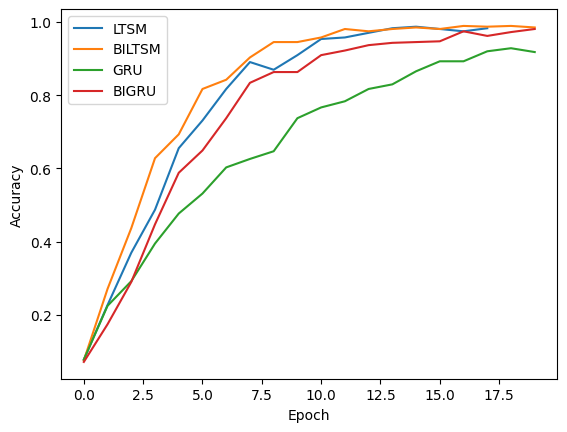

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import History

# Cargar historial del modelo

# model_history_BIGRU = pickle.load(open('historial_modelo_bilstm.pkl', 'rb'))

# Obtener los valores de accuracy para entrenamiento y validación
accuracya = model_history_LSTM.history['accuracy']
xdd =model_history_BILSTM.history['accuracy']
xd = model_history_GRU.history['accuracy']
xdaaa = model_history_BIGRU.history['accuracy']

# xdd =model_history_BIGRU.history["accuracy"]

# Graficar las curvas de accuracy
plt.plot(accuracya, label='LTSM')
plt.plot(xdd, label='BILTSM')
plt.plot(xd, label='GRU')
plt.plot(xdaaa, label='BIGRU')
# plt.plot(xdd, label='BILTSM')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### grafica de pérdida

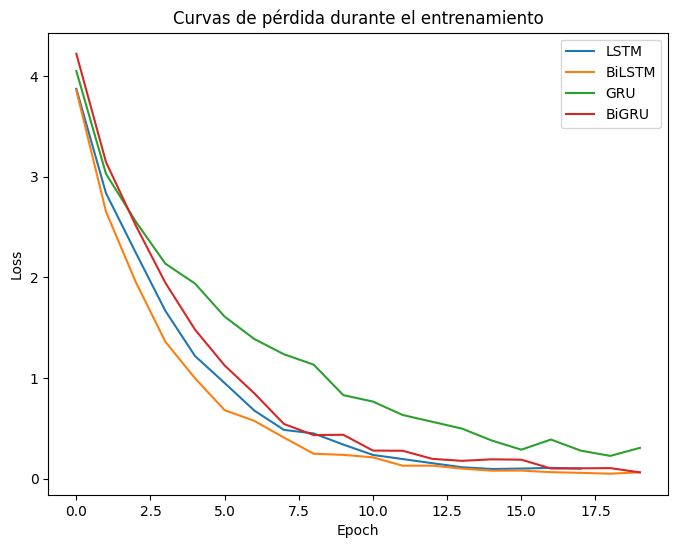

In [ ]:
loss_lstm = model_history_LSTM.history['loss']
loss_bilstm = model_history_BILSTM.history['loss']
loss_gru = model_history_GRU.history['loss']
loss_bigru = model_history_BIGRU.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(loss_lstm, label='LSTM')
plt.plot(loss_bilstm, label='BiLSTM')
plt.plot(loss_gru, label='GRU')
plt.plot(loss_bigru, label='BiGRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curvas de pérdida durante el entrenamiento')
plt.legend()
plt.show()

## Graficas de rendimiento

### tabla de datos

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predicciones para cada modelo
y_pred_lstm = modelLstm.predict(X)
y_pred_bilstm = modelBiLSTM.predict(X)
y_pred_gru = modelGru.predict(X)
y_pred_bigru = modelBiGru.predict(X)

# Accuracy
accuracy_lstm = accuracy_score(y, y_pred_lstm.argmax(axis=1))
accuracy_bilstm = accuracy_score(y, y_pred_bilstm.argmax(axis=1))
accuracy_gru = accuracy_score(y, y_pred_gru.argmax(axis=1))
accuracy_bigru = accuracy_score(y, y_pred_bigru.argmax(axis=1))

# Precision
precision_lstm = precision_score(y, y_pred_lstm.argmax(axis=1), average='weighted')
precision_bilstm = precision_score(y, y_pred_bilstm.argmax(axis=1), average='weighted')
precision_gru = precision_score(y, y_pred_gru.argmax(axis=1), average='weighted')
precision_bigru = precision_score(y, y_pred_bigru.argmax(axis=1), average='weighted')

# Recall
recall_lstm = recall_score(y, y_pred_lstm.argmax(axis=1), average='weighted')
recall_bilstm = recall_score(y, y_pred_bilstm.argmax(axis=1), average='weighted')
recall_gru = recall_score(y, y_pred_gru.argmax(axis=1), average='weighted')
recall_bigru = recall_score(y, y_pred_bigru.argmax(axis=1), average='weighted')

# F1-Score
f1_lstm = f1_score(y, y_pred_lstm.argmax(axis=1), average='weighted')
f1_bilstm = f1_score(y, y_pred_bilstm.argmax(axis=1), average='weighted')
f1_gru = f1_score(y, y_pred_gru.argmax(axis=1), average='weighted')
f1_bigru = f1_score(y, y_pred_bigru.argmax(axis=1), average='weighted')

15/15 [==============================] - 1s 38ms/step


In [ ]:
import pandas as pd

metrics = pd.DataFrame({
    'Modelo': ['LSTM', 'BiLSTM', 'GRU', 'BiGRU'],
    'Precisión': [precision_lstm, precision_bilstm, precision_gru, precision_bigru],
    'Recall': [recall_lstm, recall_bilstm, recall_gru, recall_bigru],
    'F1-Score': [f1_lstm, f1_bilstm, f1_gru, f1_bigru],
    'Accuracy': [accuracy_lstm, accuracy_bilstm, accuracy_gru, accuracy_bigru]
})

print(metrics)

   Modelo  Precisión    Recall  F1-Score  Accuracy
0    LSTM   0.994314  0.993697  0.993563  0.993697
1  BiLSTM   0.992298  0.991597  0.991491  0.991597
2     GRU   0.982564  0.981092  0.981219  0.981092
3   BiGRU   0.996265  0.995798  0.995659  0.995798


### metricas de rendimiento

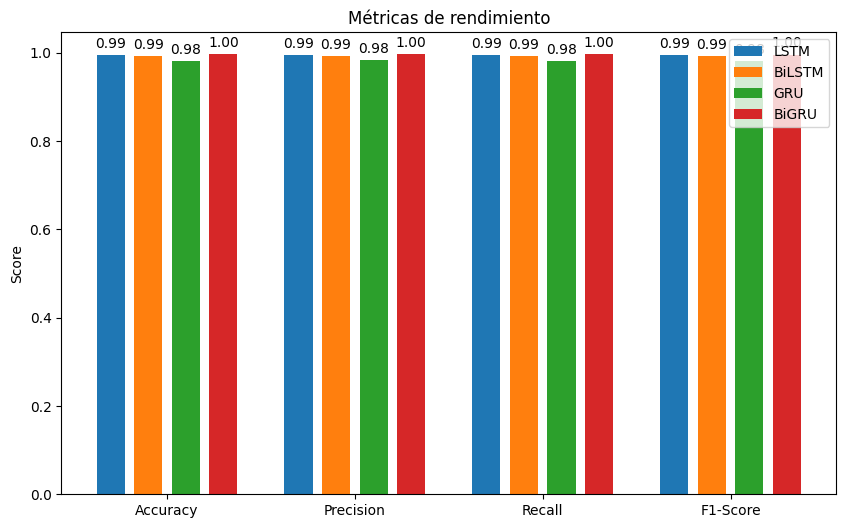

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
lstm_values = [accuracy_lstm, precision_lstm, recall_lstm, f1_lstm]
bilstm_values = [accuracy_bilstm, precision_bilstm, recall_bilstm, f1_bilstm]
gru_values = [accuracy_gru, precision_gru, recall_gru, f1_gru]
bigru_values = [accuracy_bigru, precision_bigru, recall_bigru, f1_bigru]

x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 0.3, lstm_values, width, label='LSTM')
rects2 = ax.bar(x - 0.1, bilstm_values, width, label='BiLSTM')
rects3 = ax.bar(x + 0.1, gru_values, width, label='GRU')
rects4 = ax.bar(x + 0.3, bigru_values, width, label='BiGRU')

# Agregar valores numéricos sobre cada barra
for rect in rects1 + rects2 + rects3 + rects4:
    height = rect.get_height()
    ax.annotate('{:.2f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylabel('Score')
ax.set_title('Métricas de rendimiento')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

In [ ]:
import time

# Datos de prueba
X_test = X[:100]

# Tiempo de respuesta LSTM
start_time = time.time()
lstm_predictions = modelLstm.predict(X_test)
lstm_time = time.time() - start_time

# Tiempo de respuesta BiLSTM
start_time = time.time()
bilstm_predictions = modelBiLSTM.predict(X_test)
bilstm_time = time.time() - start_time

# Tiempo de respuesta GRU
start_time = time.time()
gru_predictions = modelGru.predict(X_test)
gru_time = time.time() - start_time

# Tiempo de respuesta BiGRU
start_time = time.time()
bigru_predictions = modelBiGru.predict(X_test)
bigru_time = time.time() - start_time

print(f'Tiempo de respuesta LSTM: {lstm_time:.4f} segundos')
print(f'Tiempo de respuesta BiLSTM: {bilstm_time:.4f} segundos')
print(f'Tiempo de respuesta GRU: {gru_time:.4f} segundos')
print(f'Tiempo de respuesta BiGRU: {bigru_time:.4f} segundos')

4/4 [==============================] - 0s 39ms/step
Tiempo de respuesta LSTM: 0.7567 segundos
Tiempo de respuesta BiLSTM: 0.6500 segundos
Tiempo de respuesta GRU: 0.5351 segundos
Tiempo de respuesta BiGRU: 0.6991 segundos


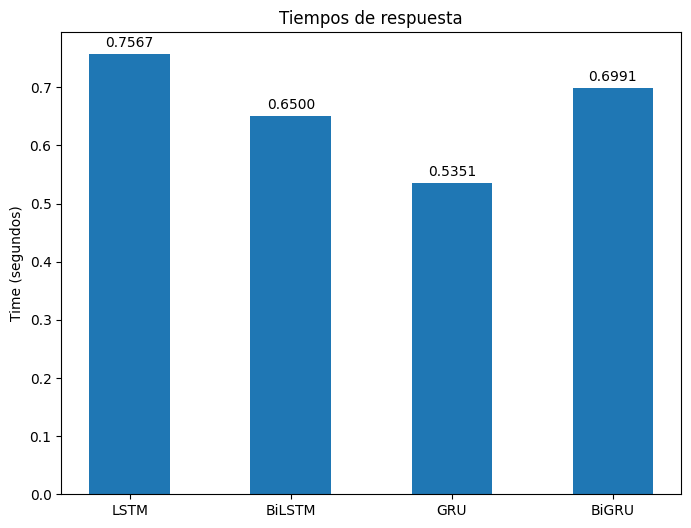

In [ ]:
import matplotlib.pyplot as plt

models = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU']
response_times = [lstm_time, bilstm_time, gru_time, bigru_time]

x = np.arange(len(models))
width = 0.5

fig, ax = plt.subplots(figsize=(8, 6))
rects = ax.bar(x, response_times, width)

# Agregar valores numéricos sobre cada barra
for rect in rects:
    height = rect.get_height()
    ax.annotate('{:.4f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylabel('Time (segundos)')
ax.set_title('Tiempos de respuesta')
ax.set_xticks(x)
ax.set_xticklabels(models)

plt.show()

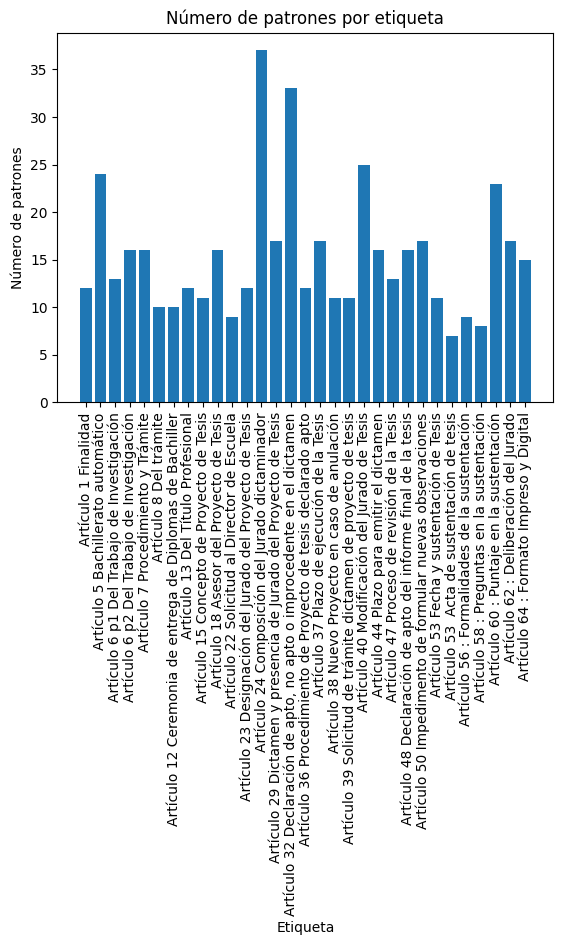

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open("chatbot.json", "r") as f:
  data = json.load(f)

# Count patterns for each tag
etiquetas = []  # Convert to a list for using as dictionary keys
numero_patrones = {}

for intent in data["intents"]:
  etiquetas.append(intent["tag"])
  numero_patrones.setdefault(intent["tag"], 0)
  numero_patrones[intent["tag"]] += len(intent["patterns"])

# Create the bar chart
plt.bar(etiquetas, numero_patrones.values(), color="#1f77b4")  # Assign default color if not defined
plt.xlabel("Etiqueta")
plt.ylabel("Número de patrones")
plt.title("Número de patrones por etiqueta")
plt.tick_params(axis='x', rotation=90)
plt.show()


In [ ]:
from keras.models import load_model

model = load_model("my_lstm_model.keras")


In [18]:
import keras

print("Keras version:", keras.__version__)


Keras version: 2.15.0


In [19]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)


TensorFlow version: 2.15.0


AttributeError: module 'tensorflow.keras' has no attribute '__version__'